In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats
import pymc3 as pm
import theano.tensor as tt
from theano.tensor.nlinalg import det
from sampled import sampled

/Users/colin/.venv/bayes_talk/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
# plt.rcParams["figure.dpi"] = 600  # for presentation figures

# Linear Regression

Define Bayesian linear regression model:

In [4]:
@sampled
def linear_regression(X=None, y=None):
    β = pm.Normal('β', mu=0, sd=10, shape=X.shape[1])
    σ = pm.HalfNormal('σ', sd=1)
    X = pm.Flat('X', observed=X)
    y = pm.Normal('y', mu=X.dot(β), sd=σ, observed=y)

Generate synthetic data, sample from model, and plot posteriors:

In [5]:
X = np.random.normal(size=(100, 4))
β = np.random.normal(size=X.shape[1])
σ = np.random.normal(size=X.shape[0])
y = X.dot(β) + σ

with linear_regression(X=X, y=y):
    posterior_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 167.44:   5%|▌         | 10421/200000 [00:00<00:14, 13399.32it/s]
Convergence archived at 11100
Interrupted at 11,100 [5%]: Average Loss = 271.04
100%|██████████| 1000/1000 [00:00<00:00, 1487.67it/s]


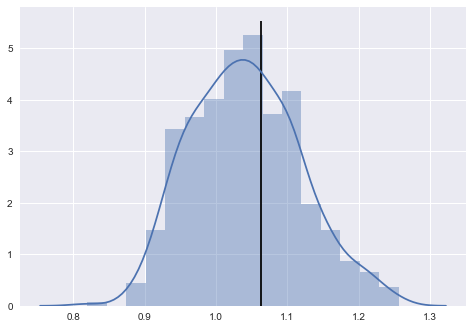

In [6]:
ax = sns.distplot(posterior_trace.get_values('σ'))
ax.vlines((σ ** 2).mean(), *ax.get_ylim());

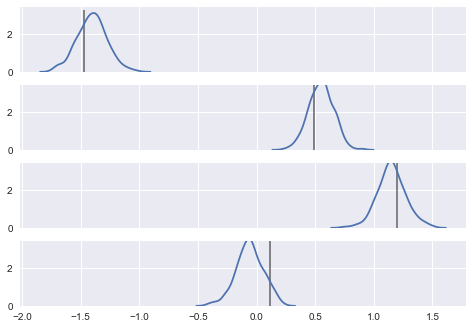

In [7]:
fig, axes = plt.subplots(nrows=len(β), sharex=True, sharey=True)

for ax, weight, true in zip(axes, posterior_trace.get_values('β').T, β):
    ax = sns.kdeplot(weight.T, ax=ax)
    ax.vlines(true, *ax.get_ylim(), alpha=0.5)
    ax.set_ylim(bottom=0)

# Inverting the CDF

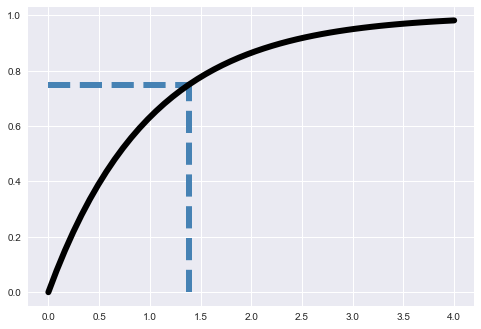

In [8]:
x = np.linspace(0, 4)
y = 1 - np.exp(-x)
plt.plot(x, y, 'k-', linewidth=6)

z = 0.75
z_inv = -np.log(1 - z)
plt.hlines(z, 0, z_inv, linestyles='dashed', colors='steelblue', linewidth=6)
plt.vlines(-np.log(1 - z), 0, z, linestyles='dashed', colors='steelblue', linewidth=6);

# Rejection Sampling

Here is a pretty general implementation, and a vectorized one for plotting.

In [9]:
def rejection_sampling(pdf, q, k, size):
    """Rejection sampling
    
    Args:
        pdf: A (possibly scaled) pdf.  Eats vectors and returns floats
        q: A scipy random variable with methods `.rv` to sample and `.pdf` to get the pdf of a point
        k: A scaling factor to make sure `kq(z) >= pdf(z)` for all `z`
        size: number of points to sample
    
    Returns:
        points: numpy array of sampled points
        draws: number of draws it took to get this many points
    """
    draws = 0
    points = []
    while len(points) < size:
        proposal = q.rvs(size=1)
        draws += 1
        accept_prob = pdf(proposal) / (k * q.pdf(proposal))
        if accept_prob > 1:
            raise RuntimeError('k isn\'t big enough at {}'.format(proposal))
        if np.random.random() < accept_prob:
            points.append(proposal)
    return points, draws

In [10]:
def two_gaussians_pdf():
    pdf_one = scipy.stats.norm(2).pdf
    pdf_two = scipy.stats.norm(-2).pdf
    def pdf(z):
        return 0.8 * pdf_one(z) + 0.2 * pdf_two(z)
    return pdf

def rejection_sample_plot(N):
    """Hard codes rejection sampling for the above 
    pdf using a hand-tuned normal distribution
    """
    one_d_unknown = two_gaussians_pdf()
    one_d_wide = scipy.stats.norm(0, 4)
    k = 1.02 * one_d_unknown(2) / one_d_wide.pdf(2)
    new_x = one_d_wide.rvs(N)
    new_y = np.random.uniform(0, k * one_d_wide.pdf(new_x))
    extent = max(abs(new_x.max()), abs(new_x.min()))
    if N > 0:
        x = np.linspace(min(-8, -1.1 * extent), max(1.1 * extent, 8), 1000)
    else:
        x = np.linspace(-8, 8, 1000)
    fig, ax = plt.subplots()
    ax.plot(x, [one_d_unknown(j) for j in x])
    ax.plot(x, [k * one_d_wide.pdf(j) for j in x])
    ax.fill_between(x, 0, [one_d_unknown(j) for j in x], alpha=0.4)
    ax.fill_between(x, 0, [k * one_d_wide.pdf(j) for j in x], alpha=0.1)

    accept = new_y <= one_d_unknown(new_x)
    ax.plot(new_x[accept], new_y[accept], marker='o', color='green', linestyle='None')
    ax.plot(new_x[~accept], new_y[~accept], marker='o', color='red', linestyle='None')

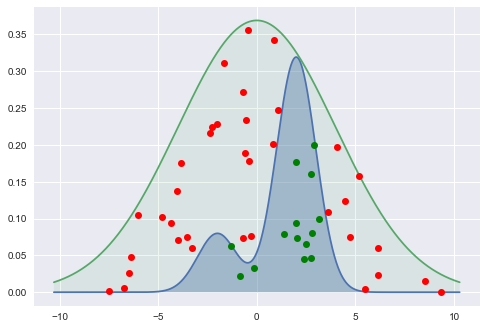

In [11]:
rejection_sample_plot(50)

# Concentration of measure

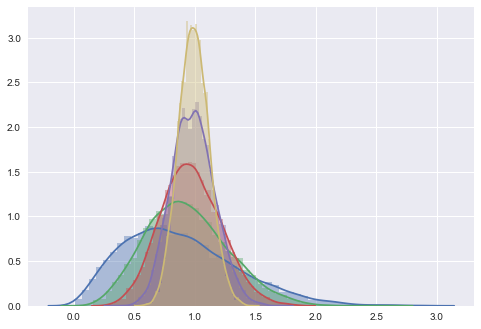

In [12]:
for N in (2, 4, 8, 16, 32):
    x = scipy.stats.multivariate_normal(cov=np.eye(N) / N).rvs(size=10000)
    _ = sns.distplot(np.linalg.norm(x, axis=1))

# Sampling from a donut

In [13]:
def jointplot(ary):
    """Helper to plot everything consistently"""
    sns.jointplot(*ary.T, alpha=0.1, stat_func=None, xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))

In [14]:
def metropolis_accept(old, new):
    """In log space -- the proposal should be symmetric!"""
    return np.log(np.random.uniform()) < new - old


def normal_proposal(scale):
    """Make a proposal for metropolis hastings from the normal distribution."""
    def proposal(x):
        return np.random.normal(x, scale)
    return proposal


def metropolis(logp, n=1000, step_size=0.15, init=np.array([1, 0])):
    """Implementation of Metropolis-Hastings.
    
    The proposal distribution is hardcoded to be a normal distribution, 
    but it will sample in whatever dimension `init` is from.  Also prints
    the acceptance rate at the end.  Optimal is ~0.234.
    """
    proposal = normal_proposal(step_size)
    accept = 0
    old = proposal(init)
    samples = []
    for _ in range(n):
        new = proposal(old)
        if metropolis_accept(logp(old), logp(new)):
            old = new
            accept += 1
        samples.append(old)
    print('Acceptance rate: {:.2f}%'.format(100 * accept / n))
    return np.array(samples)

In [15]:
def donut_pdf(scale):
    """Sample pdf for visualizations.  
    
    Normally distributed around the unit 
    circle, and the radius may be scaled.
    """
    def logp(x):
        return -((1 - np.linalg.norm(x)) / scale) ** 2
    return logp

Now we actually sample from donut distribution using the handwritten Metropolis sampler above

Acceptance rate: 21.30%


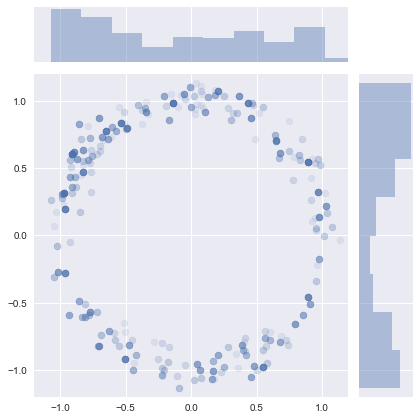

In [16]:
samples = metropolis(donut_pdf(0.1), n=1000, step_size=0.37)
jointplot(samples)

Now see how bad the sampler does with a smaller scale on the donut:

Acceptance rate: 27.20%


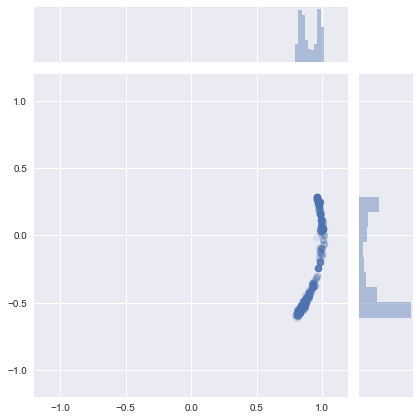

In [17]:
samples = metropolis(donut_pdf(0.01), n=1000, step_size=0.03)
jointplot(samples)

We can do the same thing with PyMC3, but we will want the pdf rewritten with `theano`.

In [18]:
def tt_donut_pdf(scale):
    """Compare to `donut_pdf`"""
    def logp(x):
         return -tt.square((1 - x.norm(2)) / scale)
    return logp

In [19]:
@sampled
def donut(scale=0.1, **observed):
    """Gets samples from the donut pdf, and allows adjusting the scale of the donut at sample time."""
    pm.DensityDist('donut', logp=tt_donut_pdf(scale), shape=2, testval=[0, 1])

100%|██████████| 1500/1500 [00:00<00:00, 11110.29it/s]


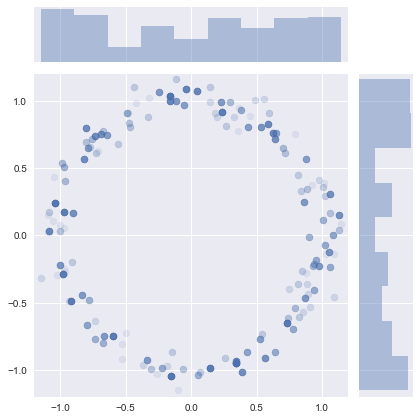

In [20]:
with donut(scale=0.1):
    metropolis_sample = pm.sample(draws=1000, step=pm.Metropolis())

jointplot(metropolis_sample.get_values('donut'))

PyMC3 also does poorly on a smaller scaled donut (because the problem is the Metropolis sampler, not my implementation!)

100%|██████████| 1500/1500 [00:00<00:00, 10816.88it/s]


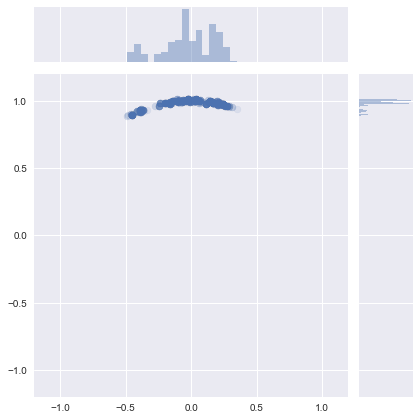

In [21]:
with donut(scale=0.01):
    metropolis_sample = pm.sample(draws=1000, step=pm.Metropolis())

jointplot(metropolis_sample.get_values('donut'))

Sample the same distributions using the Hamiltonian sampler in PyMC3.  It has no problem with either:

100%|██████████| 1500/1500 [00:02<00:00, 546.55it/s]


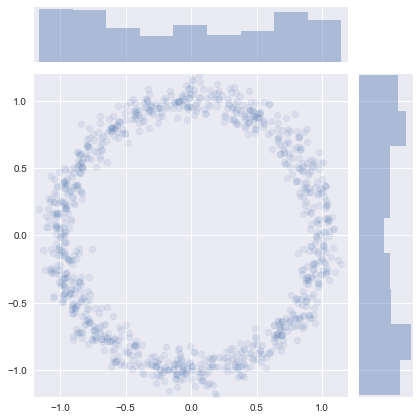

In [22]:
with donut(scale=0.1):
    nuts_sample = pm.sample(draws=1000, init=None, step=pm.NUTS())
    
jointplot(nuts_sample.get_values('donut'))

100%|█████████▉| 1494/1500 [00:20<00:00, 69.65it/s]/Users/colin/.venv/bayes_talk/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:448: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
100%|██████████| 1500/1500 [00:20<00:00, 73.47it/s]


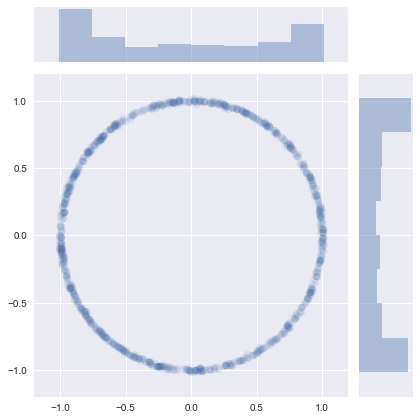

In [23]:
with donut(scale=0.01):
    nuts_sample = pm.sample(draws=1000, init=None, step=pm.NUTS())
    
jointplot(nuts_sample.get_values('donut'))

Also note that PyMC3 will make good choices if you just call `sample`:

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 23.422:   1%|          | 1885/200000 [00:00<00:10, 18845.17it/s]
Convergence archived at 2200
Interrupted at 2,200 [1%]: Average Loss = 27.687
100%|██████████| 1000/1000 [00:01<00:00, 548.43it/s]


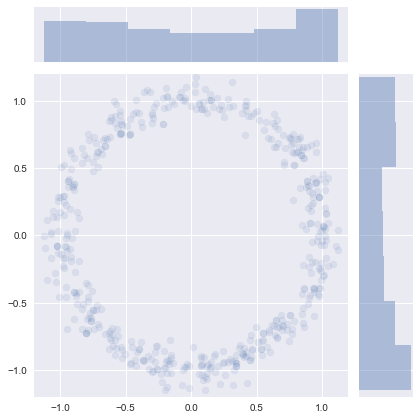

In [24]:
with donut(scale=0.1) as d:
    nuts_sample = pm.sample()
    
jointplot(nuts_sample.get_values('donut'))

$$H(q, p) = -\log \pi(p | q) - \log \pi(q)$$
$$\frac{dq}{dt} = \frac{\partial H}{\partial p}$$
$$\frac{dp}{dt} = -\frac{\partial H}{\partial q}$$

Example:

Let $\pi(q) = \mathcal{N}(0, 1)$, and $\pi(p | q) = \mathcal{N}(0, 1),$ so 
$$ H(q, p) = C + p^2 + q^2.$$

We can manually compute the gradients for these distributions in order to plot the HMC paths in 2 dimensions: 1 for position, 1 for momentum.

In [25]:
def gen_data(position, momentum, n=10000):
    """Generate a background density plot for the position and momentum distributions.  Not used for sampling."""
    q = position.rvs(n)
    p = momentum(q).rvs()
    return np.column_stack([q, p])

In [26]:
def leapfrog(q, p, dHdq, dHdp, step_size, n_steps):
    """Perform the leapfrog integration.  
    
    Similar to the implementations in PyMC3, but 
    returns an array of all the points in the path
    for plotting.  It is a pretty general 
    implementation, in that it does hardcode
    the potential or kinetic energies.
    
    Args:
        q: current position
        p: current momentum
        dHdq: see Hamilton's equations above
        dHdp: see Hamilton's equations above
        step_size: How big of a step to take
        n_steps: How many steps to take
    
    Returns:
        (`n_steps` x 2) numpy array showing the 
        path through (position, momentum) space 
        the Hamiltonian path took.
    """
    data = [[q, p]]
    p += 0.5 * step_size * -dHdq(q, p)
    q += step_size * dHdp(q, p)
    data.append([q, p])
    for _ in range(n_steps - 1):
        p += step_size * -dHdq(q, p)
        q += step_size * dHdp(q, p)
        data.append([q, p])
    p += 0.5 * step_size * -dHdq(q, p)
    return np.array(data)    

In [27]:
def leapfrog_paths(position, momentum, dHdq, dHdp, n=10):
    """Get a number `n` of paths from the HMC sampler.

    This is not quite as general -- I hardcode a step 
    size of 0.01 and 100 steps, since a path length of 1
    looked pretty good (and *not* because it is the best
    choice).  Returns an iterator of plot data.
    """
    q = position.rvs()
    p = momentum(q).rvs()
    for _ in range(n):
        path = leapfrog(q, p, dHdq, dHdp, 0.01, 100)
        yield path
        q, _ = path[-1]
        p = momentum(q).rvs()

Here we write down the distributions above, and manually compute the gradients needed to use the above two functions.

In [28]:
position = scipy.stats.norm(0, 1)
momentum = lambda q: scipy.stats.norm(0, np.ones(q.shape))
dHdp = lambda q, p: 2 * p
dHdq = lambda q, p: 2 * q

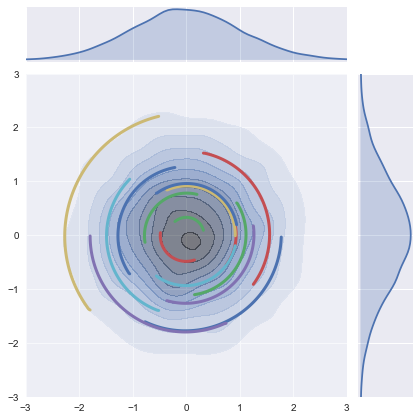

In [29]:
#  First plot a KDE of the joint pdf
X = gen_data(position, momentum)
g = sns.jointplot(*X.T, kind='kde', stat_func=None, xlim=(-3, 3), ylim=(-3, 3), alpha=0.5)

#  Now plot the Leapfrog paths on top of that
for path in leapfrog_paths(position, momentum, dHdq, dHdp, 15):
    g.ax_joint.plot(*path.T, linewidth=3)

# Volume of an N-dimensional unit sphere

It is pretty small:
$$
V_n(r) = \frac{\pi^{\frac{n}{2}}}{\Gamma \left(\frac{n}{2} + 1 \right)} r^n
$$

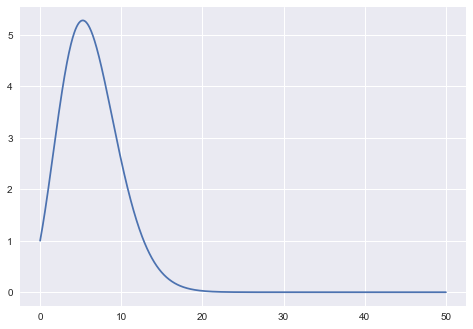

In [30]:
from scipy.special import gamma
n = np.linspace(0, 50, 1000)
V = np.power(np.pi, 0.5 * n) / gamma(0.5 * n + 1)
fig = plt.plot(n, V)

# In 20 dimensions, how many samples from an enclosing cube fall inside the unit sphere?

This actually samples from one "hyper quadrant", but by symmetry, the probability will be the same.

In [31]:
x = np.random.random(size=(20, 10000000))
((x * x).sum(axis=0) < 1).sum()

2